# JWST NIRSpec MOS data

Simple DRAFT demo notebook to view NIRSpec MOS data. In this first draft, we'll just look at the extracted 2D and 1D spectra from a single object. We'll assume you've already downloaded the s2d and x1d data from MAST (or produced them by rerunning the JWST pipeline).

See also: 
* NIRSpec MAST Query: https://github.com/spacetelescope/dat_pyinthesky/blob/main/jdat_notebooks/NIRSpec_MAST_Query/NIRSpec_MAST_Query.ipynb
* MOSViz: https://spacetelescope.github.io/jdat_notebooks/notebooks/mos_spectroscopy_advanced/MOSspec_advanced.html
* NIRSpec MOS pipeline caveats: https://jwst-docs.stsci.edu/jwst-calibration-pipeline-caveats/jwst-nirspec-mos-pipeline-caveats
* JDAT: https://jwst-docs.stsci.edu/jwst-post-pipeline-data-analysis/data-analysis-example-jupyter-notebooks

## JWST ERO program 2736: SMACS0723 – JWST's "First Deep Field"

https://webbtelescope.org/contents/news-releases/2022/news-2022-035

Press release featured objects:  
 4590 z = 8.498 (13.1 Gyr ago)  
10612 z = 7.663 (13.0 Gyr ago)  
 8140 z = 5.275 (12.6 Gyr ago)  
 9922 z = 2.743 (11.3 Gyr ago)  
and a few others:  
6355 z = 7.665  ** We'll look at this one ** excellent spectrum with bright lines  
5144 z = 6.383  

Observations:
* two pointings: s007, s008  
* G235M & G395M
* 3 slitlet nods x 2 integrations x 20 groups NRSIRS2 = 8841 s exposure time = 2.5 hours

# Import packages

In [1]:
import os
home = os.path.expanduser("~")
from glob import glob
import numpy as np
from astropy.io import fits

In [2]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'font.size': 14})  # 18

from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
import matplotlib.patheffects as pe # https://stackoverflow.com/questions/25426599/matplotlib-how-to-buffer-label-text

from astropy.visualization import simple_norm, ImageNormalize, AsinhStretch, ManualInterval, LogStretch, LinearStretch

In [3]:
import jwst
from jwst import datamodels

# Load data

In [4]:
# source_id = 6355  # z = 7.655 excellent spectrum w/ bright lines; even better than 10612 z = 7.663 in press release

data_dir = 'data'
s2d_file = 'jw02736-o007_s06355_nirspec_f290lp-g395m_s2d.fits'
s2d_file = os.path.join(data_dir, s2d_file)
s2d_file

'data/jw02736-o007_s06355_nirspec_f290lp-g395m_s2d.fits'

In [5]:
s2d_model = datamodels.open(s2d_file)  # load as datamodel
s2d_model.info()
#s2d_model.info(max_rows=99999)  # show everything

root (AsdfObject)
├─asdf_library (Software) ...
├─history (dict) ...
├─_fits_hash (str): 3f6ab50ab6ea20d518ae5fffa2fe7ee0363929dfd898de80dd6bd0dec587358b
├─con (ndarray): shape=(1, 37, 1215), dtype=int32
├─data (ndarray): shape=(37, 1215), dtype=float32
├─err (ndarray): shape=(37, 1215), dtype=float32
├─hdrtab (FITS_rec): shape=(6,), dtype=record34352
├─meta (dict) ...
├─name (str): 72
├─shutter_id (int): 30433
├─shutter_state (str): 1x111
├─slitlet_id (int): 72
├─source_alias (str): 6355
├─source_dec (float): -73.4350589621277
├─source_id (int): 6355
├─source_name (str): 2736_6355
├─source_ra (float): 110.84459416965377
├─source_type (str): EXTENDED
├─source_xpos (float): -0.0356217622756958
├─source_ypos (float): 0.36562544107437134
├─stellarity (float): 0.1
└─8 not shown
Some nodes not shown.


In [6]:
x1d_file = s2d_file.replace('s2d', 'x1d')
x1d_model = datamodels.open(x1d_file)  # load as datamodel
print(x1d_file)

data/jw02736-o007_s06355_nirspec_f290lp-g395m_x1d.fits


In [7]:
x1d_model.info()  # max_rows=99999

root (AsdfObject)
├─asdf_library (Software)
│ ├─author (str): The ASDF Developers
│ ├─homepage (str): http://github.com/asdf-format/asdf
│ ├─name (str): asdf
│ └─version (str): 2.15.0
├─history (dict)
│ └─extensions (list) ...
├─_fits_hash (str): 4190c5ef01fd3a52c43d2c6df6a9c56726cc3ecef156be05ce1e0851a20429e6
├─meta (dict)
│ ├─aperture (dict) ...
│ ├─asn (dict) ...
│ ├─background (dict)
│ ├─cal_step (dict) ...
│ ├─calibration_software_revision (str): RELEASE
│ ├─calibration_software_version (str): 1.11.4
│ ├─compress (bool): False
│ ├─data_processing_software_version (str): 2023_2a
│ ├─date (str): 2023-11-18T06:34:36.548
│ ├─dither (dict) ...
│ ├─exposure (dict) ...
│ └─23 not shown
└─spec (list) ...
Some nodes not shown.


# Show NIRSpec spectra: 2D and 1D

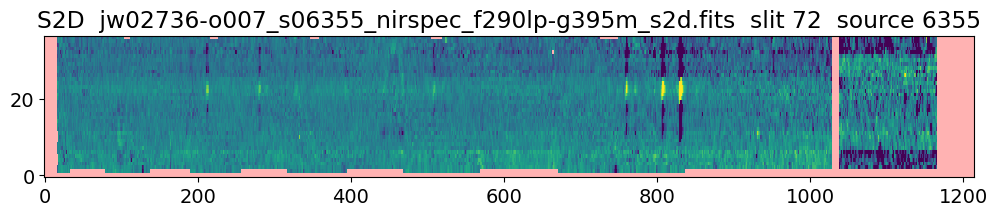

In [8]:
#data = cal.slits[i_slit].data + 0  # load and make copy
data = s2d_model.data + 0  # load and make copy
#data = np.where(s2d_model.err, data, np.nan)  # Replace zeros with nan where there is no data

# Replace zeros with nan where there is no data
s2d_err = s2d_model.err + 0
s2d_err = np.where(s2d_err, s2d_err, np.nan)
data = np.where(np.isnan(s2d_err), np.nan, data)

#cmap='viridis'
cmap = matplotlib.cm.viridis
cmap.set_bad((1,0.7,0.7),1.)  # nan color

fig, ax = plt.subplots(1, 1, figsize=(12,12))
norm = simple_norm(data, 'asinh', min_percent=2, max_percent=99.925)
im = ax.imshow(data, origin='lower', cmap=cmap, aspect='auto', norm=norm, interpolation='nearest')
title = 'S2D  ' + os.path.basename(s2d_model.meta.filename) + '  slit %d' % s2d_model.slitlet_id + '  source %d' % s2d_model.source_id
plt.title(title)
ax.set_aspect(5)

In [10]:
def show_MOS_spectrum(s2d_model, x1d_model, source_id=None, cmap='viridis', bad_color=(1,0.7,0.7), min_percent=2, max_percent=99.9):
    # 2D spectrum
    if source_id:  # s2d has all the object; extract the one with source_id
        source_ids = [slit.source_id for slit in s2d_model.slits]
        i_slit = source_ids.index(source_id)
        slit_model = s2d_model.slits[i_slit]
    else:  # s2d only has one object
        slit_model = s2d_model
        i_slit = 0
        
    s2d_data = slit_model.data + 0  # load and make copy
    s2d_data = np.where(slit_model.err, s2d_data, np.nan)  # Replace zeros with nan where there is no data

    # 1D spectrum
    x1dwave    = x1d_model.spec[i_slit].spec_table.WAVELENGTH
    x1dflux    = x1d_model.spec[i_slit].spec_table.FLUX
    x1dfluxerr = x1d_model.spec[i_slit].spec_table.FLUX_ERROR

    wave_min, wave_max = x1dwave[0], x1dwave[-1]
    eps = 1e-7
    #major_tick_interval = 0.5
    major_tick_interval = 0.2
    xtick_min = np.ceil((wave_min - eps) / major_tick_interval) * major_tick_interval
    xticks = np.arange(xtick_min, wave_max, major_tick_interval)
    #xticks = np.append(xticks, [5.2])
    num_waves = len(x1dwave)
    xtick_pos = np.interp(xticks, x1dwave, np.arange(num_waves))
    xtick_labels = ['%.1f' % xtick for xtick in xticks]
    
    #xtick_labels = [label.replace('4.8', '') for label in xtick_labels]  # remove 4.8
    # Remove any tick labels that are too close and would overlap
    for i in range(len(xtick_pos)-1):
        dx = xtick_pos[i+1] - xtick_pos[i]
        if dx < 40:
            xtick_labels[i] = ''
    
    #for label in xtick_labels: print(label, ' ', end='')

    # Make Figure
    fig, (ax2d, ax1d) = plt.subplots(2, 1, figsize=(15,8), height_ratios=[1,3], squeeze=True, sharex=True)
    cmap = matplotlib.colormaps[cmap]
    cmap.set_bad(bad_color, 1.)

    # plot the rectified 2D spectrum
    #norm = simple_norm(s2dsci, 'linear', min_percent=2, max_percent=99.9)
    norm = simple_norm(s2d_data, 'asinh', min_percent=min_percent, max_percent=max_percent)
    im = ax2d.imshow(s2d_data, origin='lower', cmap=cmap, aspect='auto', norm=norm, interpolation='nearest')
    num_cross, num_dispersion = s2d_data.shape
    width_1d = 3
    ny, nx = s2d_data.shape
    ax2d.axhline(ny/2, c='w', lw=0.5, alpha=0.5, ls='--')
    #ystart = ny/2 - 4
    #ystop  = ny/2 + 4
    #for sgn in -1,+1:
    #    ax2d.axhline(num_cross/2+sgn*width_1d, c='w', lw=0.5, alpha=0.5, ls='--')
    #for y in ystart, ystop:
    #    ax2d.axhline(y, c='w', lw=0.5, alpha=0.5, ls='--')
    
    # plot the 1D extraction  x1d vs. indices, same as s2d array above
    ax1d.step(np.arange(num_waves), x1dflux, lw=1)
    ax1d.set_xlim(0, num_waves)
    
    title = 'S2D  ' + os.path.basename(s2d_model.meta.filename) 
    title += '  slit %d'   % slit_model.slitlet_id
    title += '  source %d' % slit_model.source_id
    ax2d.set_title(title)
    plt.xticks(xtick_pos, xtick_labels)
    plt.xlabel('wavelength (microns)');

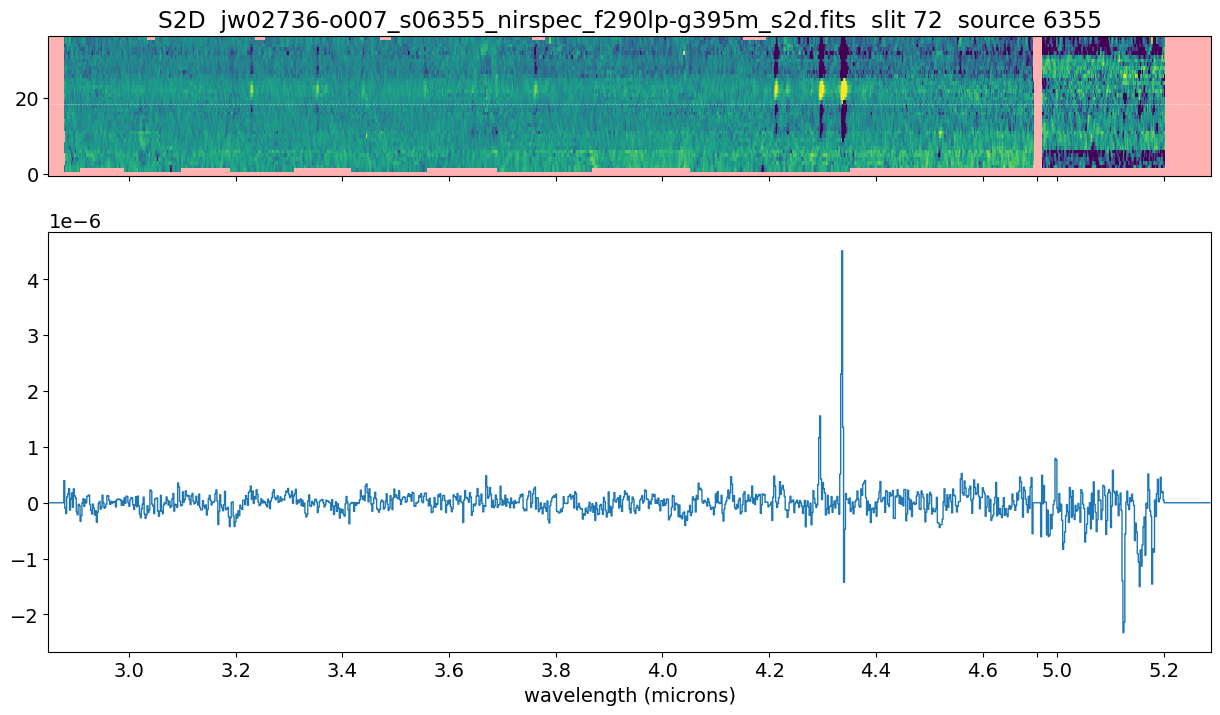

In [11]:
show_MOS_spectrum(s2d_model, x1d_model)

Note the 1D extraction sometimes misses the signal. This can be improved significantly simply by tweaking the extraction rows ystart – ystop as we'll demonstrate in another notebook in prep. Also note the x1d file doesn't save the ystart – ystop range used. Above I just drew a dashed line along the center row.